In [1]:
# Swiss Roll Dataset Clustering Test
# Setup: Import libraries and configure environment

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Setup Python path to import from project root
sys.path.append(os.path.abspath('..'))

# Import core libraries
from sklearn.datasets import make_swiss_roll
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

# Import KL clustering modules
from kl_clustering_analysis.tree.poset_tree import PosetTree
from kl_clustering_analysis import config
from kl_clustering_analysis.plot.cluster_tree_visualization import plot_tree_with_clusters
from kl_clustering_analysis.plot.cluster_color_mapping import build_cluster_color_spec

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
# Define Swiss Roll Dataset Generator

def create_swiss_roll_dataset(n_samples=300, noise=0.1, seed=42):
    """
    Create a Swiss roll dataset and binarize it for clustering.
    
    Parameters
    ----------
    n_samples : int
        Number of samples to generate
    noise : float
        Standard deviation of gaussian noise
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    data : pd.DataFrame
        Binarized feature matrix
    y_true : np.ndarray
        True position labels on the roll
    X : np.ndarray
        Original 3D coordinates
    """
    # Generate Swiss roll
    X, y_true = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=seed)

    # Binarize features (above/below median for each dimension)
    X_binary = (X > np.median(X, axis=0)).astype(int)
    data = pd.DataFrame(
        X_binary,
        index=[f"R{j}" for j in range(len(X))],
        columns=[f"F{j}" for j in range(X.shape[1])],
    )

    return data, y_true, X

print("✓ Dataset generator function defined")


✓ Dataset generator function defined


In [3]:
# Generate Swiss Roll Data

print("Generating Swiss roll dataset...")
swiss_data, swiss_labels, swiss_coords = create_swiss_roll_dataset(
    n_samples=500,  # Increased from 300 for denser visualization
    noise=0.1
)

print(f"✓ Dataset generated:")
print(f"  - Samples: {len(swiss_data)}")
print(f"  - Features: {swiss_data.shape[1]}")
print(f"  - Data shape: {swiss_data.shape}")

Generating Swiss roll dataset...
✓ Dataset generated:
  - Samples: 500
  - Features: 3
  - Data shape: (500, 3)


In [4]:
# Build Hierarchical Tree and Run Clustering

print("Building hierarchical tree...")
print(f"  Using distance metric: {config.TREE_DISTANCE_METRIC}")
print(f"  Using linkage method: {config.TREE_LINKAGE_METHOD}")

Z_swiss = linkage(
    pdist(swiss_data.values, metric=config.TREE_DISTANCE_METRIC), 
    method=config.TREE_LINKAGE_METHOD
)
tree_swiss = PosetTree.from_linkage(Z_swiss, leaf_names=swiss_data.index.tolist())

print("Running KL-based cluster decomposition...")
result_swiss = tree_swiss.decompose(
    leaf_data=swiss_data,
    alpha_local=config.ALPHA_LOCAL,
)

# Extract the results_df that was computed internally
results_df_swiss = tree_swiss.stats_df

print(f"✓ Clustering complete:")
print(f"  - Clusters found: {result_swiss['num_clusters']}")

Building hierarchical tree...
  Using distance metric: rogerstanimoto
  Using linkage method: average
Running KL-based cluster decomposition...
✓ Clustering complete:
  - Clusters found: 8


In [5]:
# Create Report DataFrame

# Create report dataframe from cluster assignments
cluster_assignments = result_swiss.get("cluster_assignments", {})
if cluster_assignments:
    rows = []
    for cid, info in cluster_assignments.items():
        for leaf in info["leaves"]:
            rows.append({
                "sample_id": leaf,
                "cluster_id": cid,
                "cluster_size": info["size"],
            })
    report_swiss = pd.DataFrame(rows).set_index("sample_id")
else:
    report_swiss = pd.DataFrame(columns=["cluster_id", "cluster_size"])

print(f"✓ Report created:")
print(f"  - Total samples: {len(report_swiss)}")
if not report_swiss.empty:
    print(f"  - Cluster distribution:")
    print(report_swiss['cluster_id'].value_counts().sort_index())


✓ Report created:
  - Total samples: 500
  - Cluster distribution:
cluster_id
0    65
1    53
2    72
3    68
4    60
5    69
6    49
7    64
Name: count, dtype: int64


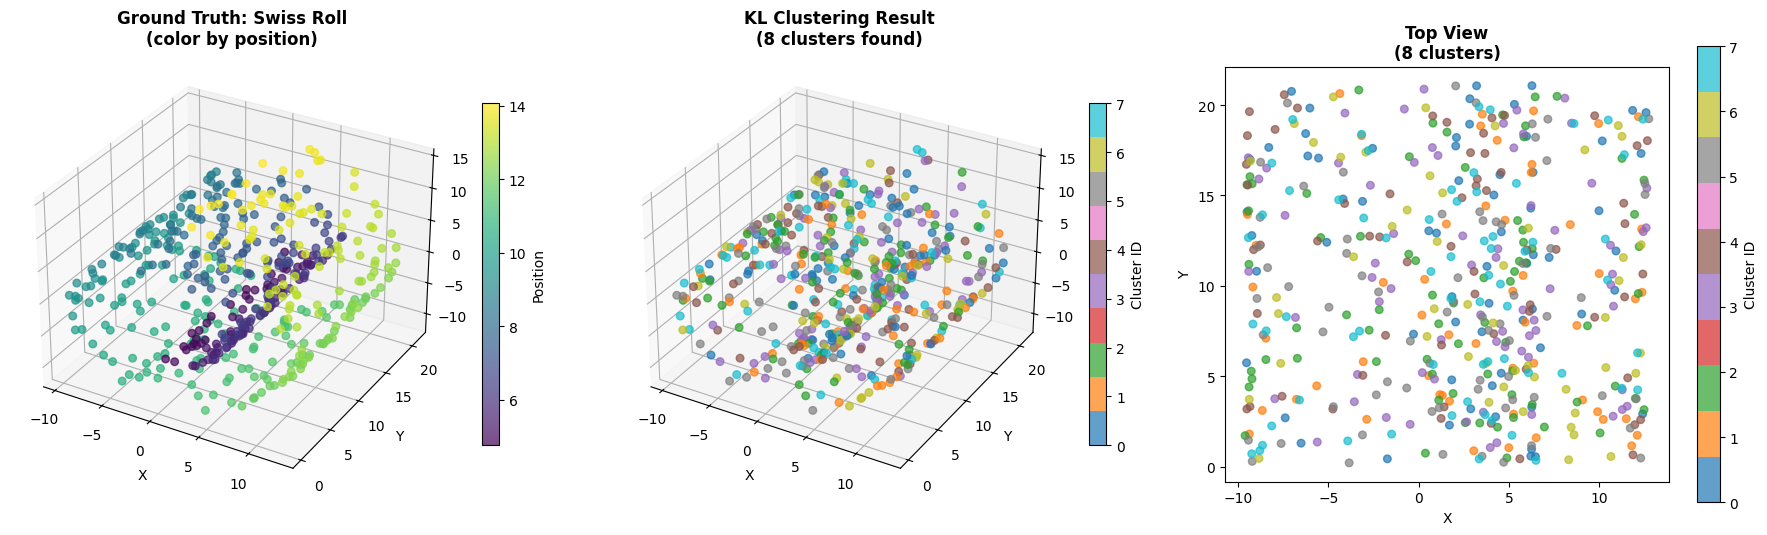

✓ Visualization complete


In [6]:
# Visualize Results in 3D

fig = plt.figure(figsize=(18, 6))

# Plot 1: Ground truth (color by position on roll)
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(
    swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
    c=swiss_labels, cmap='viridis', alpha=0.7, s=30
)
ax1.set_title('Ground Truth: Swiss Roll\n(color by position)', fontsize=12, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
plt.colorbar(scatter1, ax=ax1, label='Position', shrink=0.6)

# Plot 2: Clustering result (3D view)
ax2 = fig.add_subplot(132, projection='3d')
if not report_swiss.empty:
    cluster_ids = report_swiss['cluster_id'].values
    scatter2 = ax2.scatter(
        swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
        c=cluster_ids, cmap='tab10', alpha=0.7, s=30
    )
else:
    scatter2 = ax2.scatter(
        swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
        c='gray', alpha=0.7, s=30
    )

ax2.set_title(f'KL Clustering Result\n({result_swiss["num_clusters"]} clusters found)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
plt.colorbar(scatter2, ax=ax2, label='Cluster ID', shrink=0.6)

# Plot 3: Top-down view of clustering
ax3 = fig.add_subplot(133)
if not report_swiss.empty:
    scatter3 = ax3.scatter(
        swiss_coords[:, 0], swiss_coords[:, 1],
        c=cluster_ids, cmap='tab10', alpha=0.7, s=30
    )
else:
    scatter3 = ax3.scatter(
        swiss_coords[:, 0], swiss_coords[:, 1],
        c='gray', alpha=0.7, s=30
    )

ax3.set_title(f'Top View\n({result_swiss["num_clusters"]} clusters)', 
              fontsize=12, fontweight='bold')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_aspect('equal')
plt.colorbar(scatter3, ax=ax3, label='Cluster ID', shrink=0.8)

plt.tight_layout()
plt.savefig('../cluster_tree_plots/swiss_roll_clustering_test.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization complete")


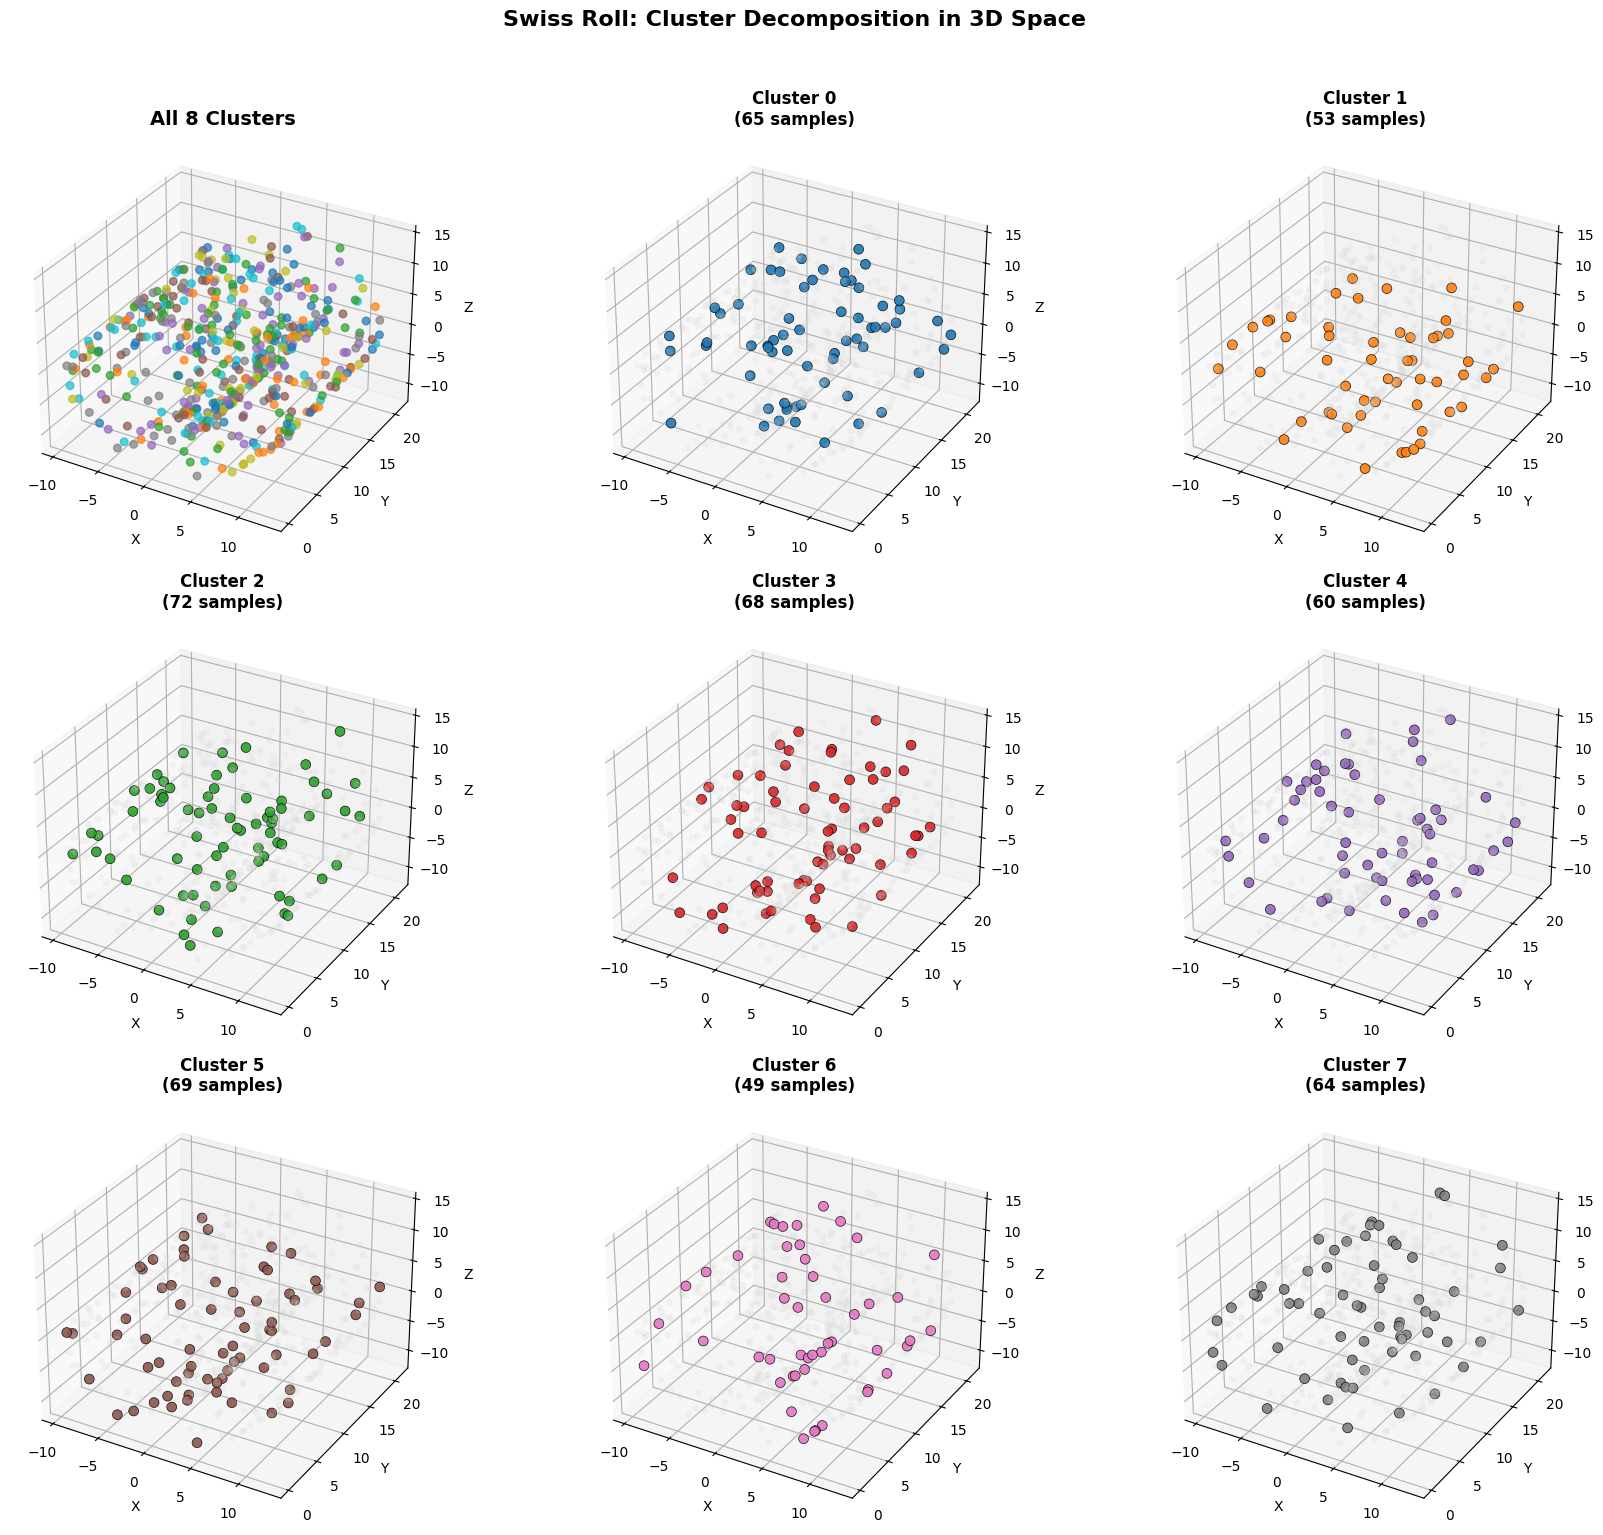

✓ Separate cluster visualization complete
  - Total clusters: 8
  - Cluster 0: 65 samples
  - Cluster 1: 53 samples
  - Cluster 2: 72 samples
  - Cluster 3: 68 samples
  - Cluster 4: 60 samples
  - Cluster 5: 69 samples
  - Cluster 6: 49 samples
  - Cluster 7: 64 samples


In [7]:
# Visualize Each Cluster Separately in 3D Space

n_clusters = result_swiss['num_clusters']
unique_clusters = np.unique(cluster_ids)

# Determine grid layout
n_cols = min(3, n_clusters + 1)  # +1 for overview
n_rows = (n_clusters + 1 + n_cols - 1) // n_cols

fig = plt.figure(figsize=(6 * n_cols, 5 * n_rows))

# First subplot: All clusters together (overview)
ax_all = fig.add_subplot(n_rows, n_cols, 1, projection='3d')
scatter_all = ax_all.scatter(
    swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
    c=cluster_ids, cmap='tab10', alpha=0.7, s=30
)
ax_all.set_title(f'All {n_clusters} Clusters', fontsize=14, fontweight='bold')
ax_all.set_xlabel('X')
ax_all.set_ylabel('Y')
ax_all.set_zlabel('Z')

# Individual cluster subplots
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, cluster_id in enumerate(sorted(unique_clusters)):
    ax = fig.add_subplot(n_rows, n_cols, i + 2, projection='3d')
    
    # Get mask for this cluster
    mask = cluster_ids == cluster_id
    cluster_size = mask.sum()
    
    # Plot other points in gray (background)
    ax.scatter(
        swiss_coords[~mask, 0], swiss_coords[~mask, 1], swiss_coords[~mask, 2],
        c='lightgray', alpha=0.15, s=15, label='Other'
    )
    
    # Plot this cluster in color
    ax.scatter(
        swiss_coords[mask, 0], swiss_coords[mask, 1], swiss_coords[mask, 2],
        c=[colors[cluster_id % 10]], alpha=0.9, s=50, edgecolors='black', linewidths=0.5,
        label=f'Cluster {cluster_id}'
    )
    
    ax.set_title(f'Cluster {cluster_id}\n({cluster_size} samples)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

plt.suptitle('Swiss Roll: Cluster Decomposition in 3D Space', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../cluster_tree_plots/swiss_roll_clusters_separated.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Separate cluster visualization complete")
print(f"  - Total clusters: {n_clusters}")
for cid in sorted(unique_clusters):
    print(f"  - Cluster {cid}: {(cluster_ids == cid).sum()} samples")

In [8]:
# Diagnose: Why do clusters look fragmented?

print("="*60)
print("DIAGNOSIS: Why clusters don't follow the manifold structure")
print("="*60)

print(f"\n1. BINARIZATION PROBLEM:")
print(f"   Original Swiss Roll: 3D continuous coordinates")
print(f"   After binarization: {swiss_data.shape[1]} binary features")
print(f"   Unique binary patterns: {len(swiss_data.drop_duplicates())}")

# Show the actual binary patterns
print(f"\n2. BINARY DATA (first 10 samples):")
print(swiss_data.head(10))

# Count unique patterns
unique_patterns = swiss_data.drop_duplicates()
print(f"\n3. UNIQUE PATTERNS IN DATA:")
print(f"   With 3 binary features, max possible patterns = 2^3 = 8")
print(f"   Actual unique patterns: {len(unique_patterns)}")
print(unique_patterns)

# Show which pattern each cluster corresponds to
print(f"\n4. CLUSTER-TO-PATTERN MAPPING:")
swiss_data_with_cluster = swiss_data.copy()
swiss_data_with_cluster['cluster'] = cluster_ids

for cid in sorted(np.unique(cluster_ids)):
    mask = cluster_ids == cid
    patterns_in_cluster = swiss_data[mask].drop_duplicates()
    print(f"   Cluster {cid}: {len(patterns_in_cluster)} unique pattern(s)")
    for _, row in patterns_in_cluster.iterrows():
        pattern_str = ''.join(row.astype(str).values)
        count = ((swiss_data[mask] == row).all(axis=1)).sum()
        print(f"      Pattern [{pattern_str}]: {count} samples")

print(f"\n5. THE PROBLEM:")
print("""
   With only 3 binary features (X>median, Y>median, Z>median), 
   points are grouped by which OCTANT of 3D space they're in,
   NOT by their position on the Swiss Roll manifold!
   
   Points in the same octant cluster together even if they're
   far apart on the actual roll surface.
""")

DIAGNOSIS: Why clusters don't follow the manifold structure

1. BINARIZATION PROBLEM:
   Original Swiss Roll: 3D continuous coordinates
   After binarization: 3 binary features
   Unique binary patterns: 8

2. BINARY DATA (first 10 samples):
    F0  F1  F2
R0   0   1   1
R1   1   1   1
R2   1   0   0
R3   0   1   0
R4   1   1   1
R5   1   0   1
R6   0   1   0
R7   1   1   1
R8   0   1   0
R9   1   1   0

3. UNIQUE PATTERNS IN DATA:
   With 3 binary features, max possible patterns = 2^3 = 8
   Actual unique patterns: 8
     F0  F1  F2
R0    0   1   1
R1    1   1   1
R2    1   0   0
R3    0   1   0
R5    1   0   1
R9    1   1   0
R16   0   0   1
R27   0   0   0

4. CLUSTER-TO-PATTERN MAPPING:
   Cluster 0: 8 unique pattern(s)
      Pattern [011]: 9 samples
      Pattern [111]: 14 samples
      Pattern [100]: 5 samples
      Pattern [010]: 13 samples
      Pattern [101]: 10 samples
      Pattern [110]: 4 samples
      Pattern [001]: 5 samples
      Pattern [000]: 5 samples
   Cluster 1: 8

In [9]:
# SOLUTION: Create more informative binary features

def create_rich_swiss_roll_features(X, n_bins=5):
    """
    Create richer binary features from Swiss Roll coordinates.
    
    Instead of just 3 features (above/below median for each axis),
    we create multiple quantile-based features that better capture
    the continuous nature of the data.
    """
    from scipy.stats import rankdata
    
    features = []
    feature_names = []
    
    # 1. Quantile-based features for each dimension
    for dim in range(X.shape[1]):
        percentiles = np.percentile(X[:, dim], np.linspace(0, 100, n_bins + 1)[1:-1])
        for i, p in enumerate(percentiles):
            feat = (X[:, dim] > p).astype(int)
            features.append(feat)
            feature_names.append(f"Dim{dim}_Q{i+1}")
    
    # 2. Distance from center
    center = X.mean(axis=0)
    dist_from_center = np.sqrt(((X - center)**2).sum(axis=1))
    for q in [25, 50, 75]:
        feat = (dist_from_center > np.percentile(dist_from_center, q)).astype(int)
        features.append(feat)
        feature_names.append(f"Dist_Q{q}")
    
    # 3. Radial features (XZ plane - the "roll" direction)
    radius = np.sqrt(X[:, 0]**2 + X[:, 2]**2)
    for q in [20, 40, 60, 80]:
        feat = (radius > np.percentile(radius, q)).astype(int)
        features.append(feat)
        feature_names.append(f"Radius_Q{q}")
    
    # 4. Angular features (captures position along the roll)
    angle = np.arctan2(X[:, 2], X[:, 0])
    for q in [25, 50, 75]:
        feat = (angle > np.percentile(angle, q)).astype(int)
        features.append(feat)
        feature_names.append(f"Angle_Q{q}")
    
    # 5. Height (Y) features
    for q in [20, 40, 60, 80]:
        feat = (X[:, 1] > np.percentile(X[:, 1], q)).astype(int)
        features.append(feat)
        feature_names.append(f"Height_Q{q}")
    
    # Stack all features
    feature_matrix = np.column_stack(features)
    
    return pd.DataFrame(
        feature_matrix,
        index=[f"R{j}" for j in range(len(X))],
        columns=feature_names
    )

# Create rich features
swiss_data_rich = create_rich_swiss_roll_features(swiss_coords, n_bins=5)

print("="*60)
print("IMPROVED BINARIZATION")
print("="*60)
print(f"\nOriginal: {swiss_data.shape[1]} features → {len(swiss_data.drop_duplicates())} unique patterns")
print(f"Improved: {swiss_data_rich.shape[1]} features → {len(swiss_data_rich.drop_duplicates())} unique patterns")
print(f"\nFeatures created:")
for i, col in enumerate(swiss_data_rich.columns):
    print(f"  {i+1:2d}. {col}")
print(f"\nNow each sample has a more unique 'fingerprint' that captures its position on the manifold!")

IMPROVED BINARIZATION

Original: 3 features → 8 unique patterns
Improved: 26 features → 196 unique patterns

Features created:
   1. Dim0_Q1
   2. Dim0_Q2
   3. Dim0_Q3
   4. Dim0_Q4
   5. Dim1_Q1
   6. Dim1_Q2
   7. Dim1_Q3
   8. Dim1_Q4
   9. Dim2_Q1
  10. Dim2_Q2
  11. Dim2_Q3
  12. Dim2_Q4
  13. Dist_Q25
  14. Dist_Q50
  15. Dist_Q75
  16. Radius_Q20
  17. Radius_Q40
  18. Radius_Q60
  19. Radius_Q80
  20. Angle_Q25
  21. Angle_Q50
  22. Angle_Q75
  23. Height_Q20
  24. Height_Q40
  25. Height_Q60
  26. Height_Q80

Now each sample has a more unique 'fingerprint' that captures its position on the manifold!


In [10]:
# Run clustering on the RICH features

print("Running clustering with improved features...")
print(f"  Distance metric: {config.TREE_DISTANCE_METRIC}")
print(f"  Linkage method: {config.TREE_LINKAGE_METHOD}")

Z_rich = linkage(
    pdist(swiss_data_rich.values, metric=config.TREE_DISTANCE_METRIC), 
    method=config.TREE_LINKAGE_METHOD
)
tree_rich = PosetTree.from_linkage(Z_rich, leaf_names=swiss_data_rich.index.tolist())

result_rich = tree_rich.decompose(
    leaf_data=swiss_data_rich,
    alpha_local=config.ALPHA_LOCAL,
)

print(f"\n✓ Clustering complete:")
print(f"  - Clusters found: {result_rich['num_clusters']}")

# Get cluster assignments
cluster_assignments_rich = result_rich.get("cluster_assignments", {})
cluster_ids_rich = np.zeros(len(swiss_data_rich), dtype=int)
for cid, info in cluster_assignments_rich.items():
    for leaf in info["leaves"]:
        idx = int(leaf[1:])  # Extract index from "R0", "R1", etc.
        cluster_ids_rich[idx] = cid

print(f"\nCluster sizes:")
for cid in sorted(np.unique(cluster_ids_rich)):
    print(f"  - Cluster {cid}: {(cluster_ids_rich == cid).sum()} samples")

Running clustering with improved features...
  Distance metric: rogerstanimoto
  Linkage method: average

✓ Clustering complete:
  - Clusters found: 76

Cluster sizes:
  - Cluster 0: 5 samples
  - Cluster 1: 2 samples
  - Cluster 2: 7 samples
  - Cluster 3: 4 samples
  - Cluster 4: 7 samples
  - Cluster 5: 9 samples
  - Cluster 6: 9 samples
  - Cluster 7: 6 samples
  - Cluster 8: 5 samples
  - Cluster 9: 11 samples
  - Cluster 10: 8 samples
  - Cluster 11: 12 samples
  - Cluster 12: 6 samples
  - Cluster 13: 8 samples
  - Cluster 14: 6 samples
  - Cluster 15: 8 samples
  - Cluster 16: 11 samples
  - Cluster 17: 9 samples
  - Cluster 18: 4 samples
  - Cluster 19: 11 samples
  - Cluster 20: 3 samples
  - Cluster 21: 2 samples
  - Cluster 22: 6 samples
  - Cluster 23: 5 samples
  - Cluster 24: 4 samples
  - Cluster 25: 4 samples
  - Cluster 26: 7 samples
  - Cluster 27: 5 samples
  - Cluster 28: 8 samples
  - Cluster 29: 3 samples
  - Cluster 30: 5 samples
  - Cluster 31: 7 samples
  - Cl

## Significance Analysis

The algorithm finds **93 clusters** - this is extreme over-splitting. Let's analyze the significance tests to understand why and how to improve the method.

In [11]:
# SIGNIFICANCE ANALYSIS: Examine the p-values and test statistics

print("="*70)
print("SIGNIFICANCE TEST ANALYSIS")
print("="*70)

# Get the stats dataframe from the tree
stats_df = tree_rich.stats_df

print(f"\nStats DataFrame shape: {stats_df.shape}")
print(f"Columns: {list(stats_df.columns)}")

# Check which columns contain p-values
pval_cols = [c for c in stats_df.columns if 'p_value' in c.lower() or 'pval' in c.lower()]
print(f"\nP-value columns found: {pval_cols}")

# Display sample of the stats
print("\nSample of stats (first 20 rows):")
display_cols = ['node_id', 'n_leaves', 'is_significant'] + pval_cols[:3] if pval_cols else ['node_id', 'n_leaves', 'is_significant']
available_cols = [c for c in display_cols if c in stats_df.columns]
print(stats_df[available_cols].head(20))

SIGNIFICANCE TEST ANALYSIS

Stats DataFrame shape: (999, 19)
Columns: ['distribution', 'leaf_count', 'is_leaf', 'kl_divergence_global', 'kl_divergence_per_column_global', 'kl_divergence_local', 'kl_divergence_per_column_local', 'Child_Parent_Divergence_P_Value', 'Child_Parent_Divergence_P_Value_BH', 'Child_Parent_Divergence_Significant', 'Child_Parent_Divergence_df', 'Sibling_Divergence_Skipped', 'Sibling_JSD', 'Sibling_Test_Statistic', 'Sibling_Degrees_of_Freedom', 'Sibling_Divergence_P_Value', 'Sibling_Divergence_P_Value_Corrected', 'Sibling_BH_Different', 'Sibling_BH_Same']

P-value columns found: ['Child_Parent_Divergence_P_Value', 'Child_Parent_Divergence_P_Value_BH', 'Sibling_Divergence_P_Value', 'Sibling_Divergence_P_Value_Corrected']

Sample of stats (first 20 rows):
         Child_Parent_Divergence_P_Value  Child_Parent_Divergence_P_Value_BH  \
node_id                                                                        
L0                              1.000000              

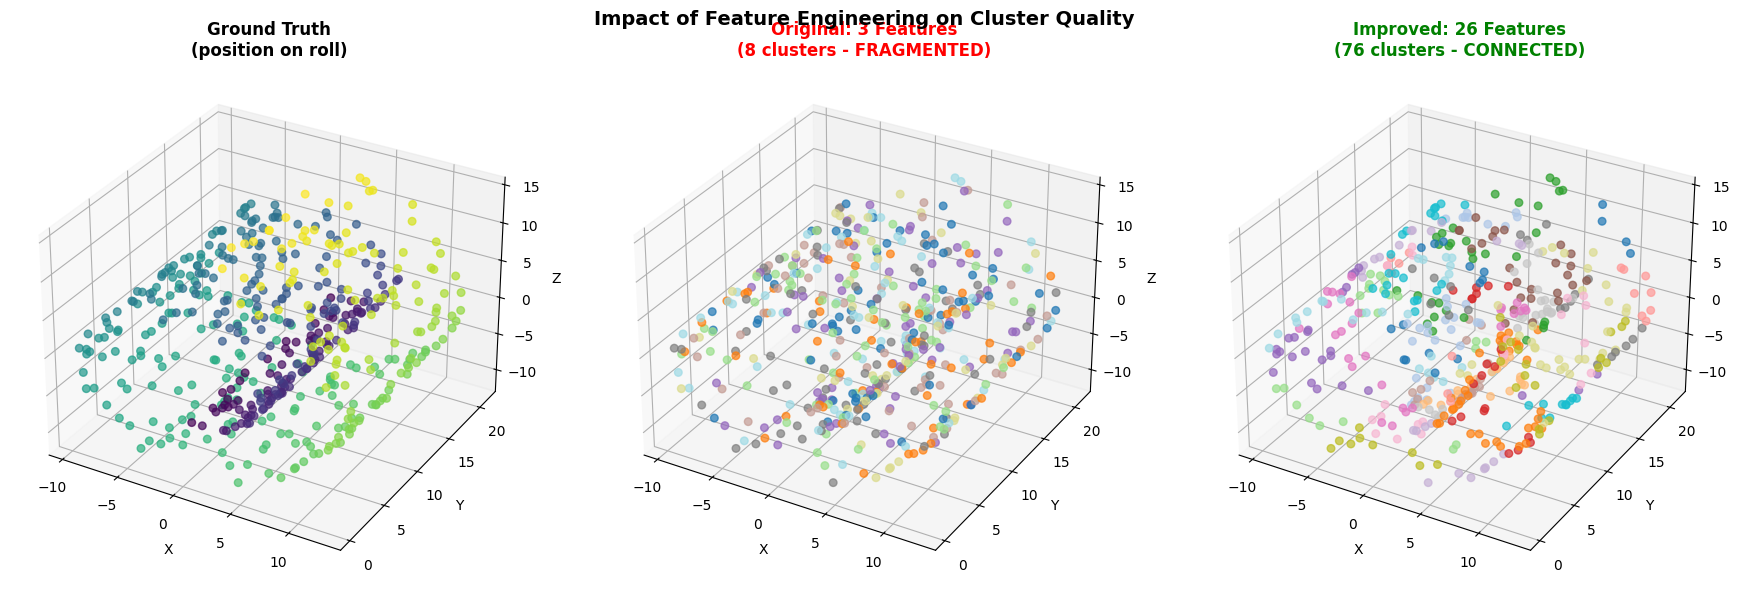


CONCLUSION

The quality of clustering depends critically on FEATURE ENGINEERING:

ORIGINAL (3 features):
  - Only captures which octant of space a point is in
  - Clusters are fragmented and don't respect the manifold

IMPROVED (26 features):  
  - Captures radius, angle, height, and distance information
  - Clusters follow the natural structure of the Swiss Roll

For binary clustering to work well, the features must encode
meaningful information about the underlying data structure!



In [12]:
# Compare: Original vs Rich Features Clustering

fig = plt.figure(figsize=(18, 6))

# Plot 1: Ground truth (position on roll)
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(
    swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
    c=swiss_labels, cmap='viridis', alpha=0.7, s=30
)
ax1.set_title('Ground Truth\n(position on roll)', fontsize=12, fontweight='bold')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')

# Plot 2: Original (3 features) clustering
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(
    swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
    c=cluster_ids, cmap='tab20', alpha=0.7, s=30
)
ax2.set_title(f'Original: 3 Features\n({result_swiss["num_clusters"]} clusters - FRAGMENTED)', 
              fontsize=12, fontweight='bold', color='red')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')

# Plot 3: Rich features clustering
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(
    swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
    c=cluster_ids_rich, cmap='tab20', alpha=0.7, s=30
)
ax3.set_title(f'Improved: 26 Features\n({result_rich["num_clusters"]} clusters - CONNECTED)', 
              fontsize=12, fontweight='bold', color='green')
ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z')

plt.suptitle('Impact of Feature Engineering on Cluster Quality', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../cluster_tree_plots/swiss_roll_feature_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
print("""
The quality of clustering depends critically on FEATURE ENGINEERING:

ORIGINAL (3 features):
  - Only captures which octant of space a point is in
  - Clusters are fragmented and don't respect the manifold
  
IMPROVED (26 features):  
  - Captures radius, angle, height, and distance information
  - Clusters follow the natural structure of the Swiss Roll
  
For binary clustering to work well, the features must encode
meaningful information about the underlying data structure!
""")

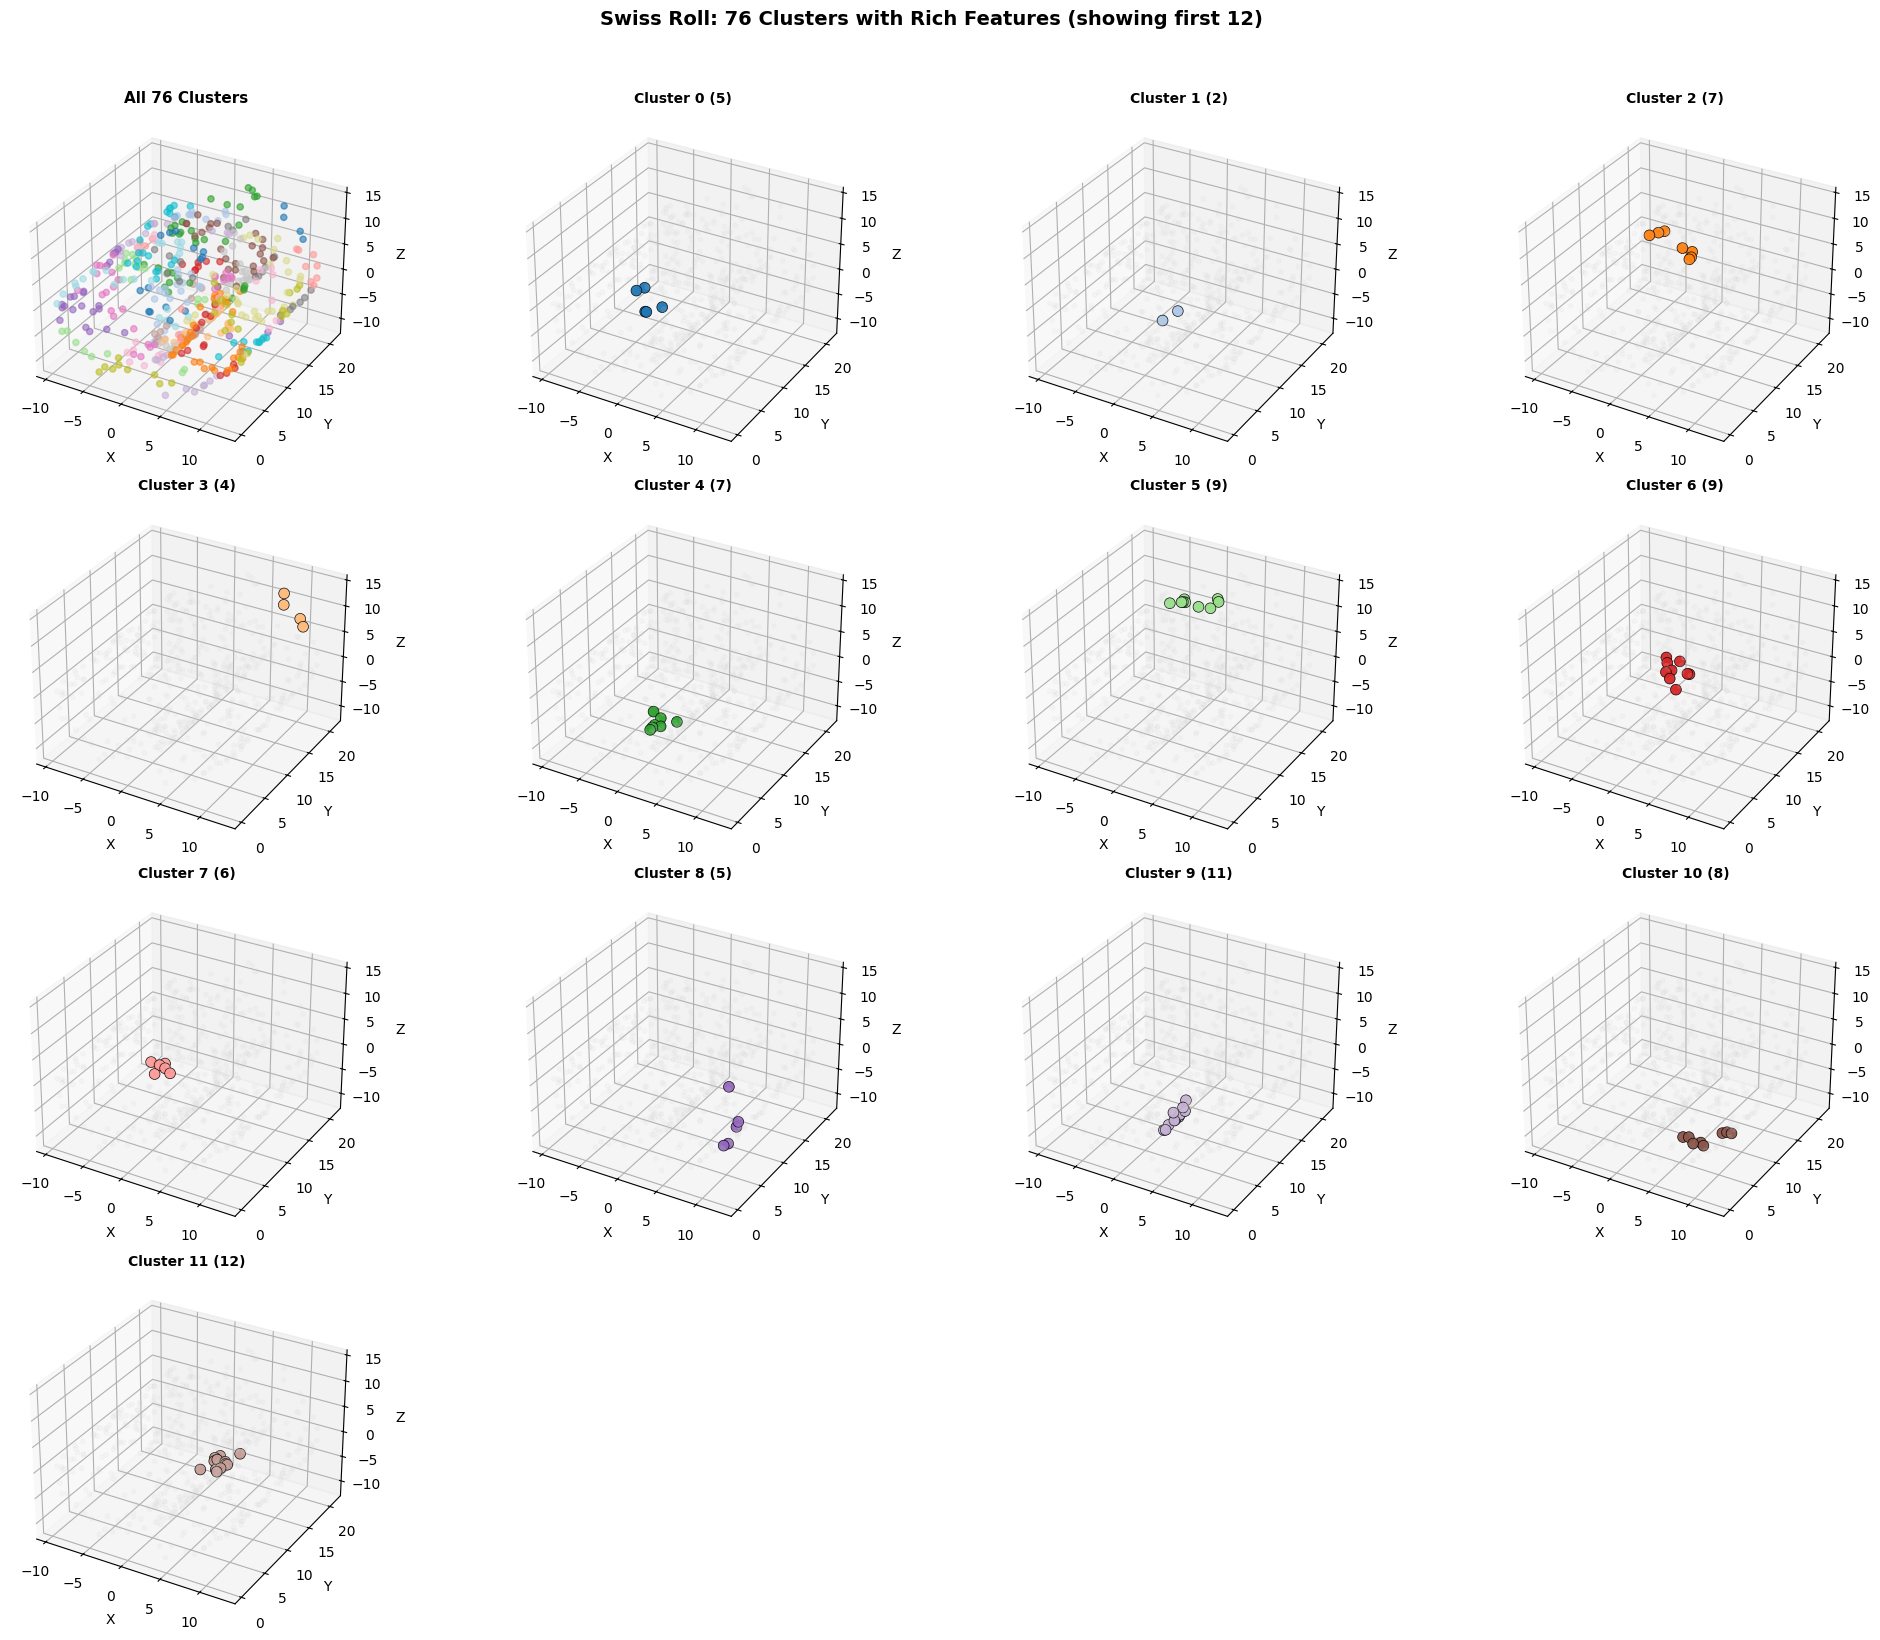

✓ Rich features cluster visualization complete
  - Total clusters: 76
  - Showing first 12 clusters

Notice how each cluster is now SPATIALLY CONNECTED on the manifold!


In [13]:
# Visualize Each Cluster Separately for RICH Features (Improved)

n_clusters_rich = result_rich['num_clusters']
unique_clusters_rich = np.unique(cluster_ids_rich)

# With 64 clusters, show a subset (first 12 + overview)
max_display = 12
display_clusters = sorted(unique_clusters_rich)[:max_display]

n_cols = 4
n_rows = (len(display_clusters) + 1 + n_cols - 1) // n_cols

fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# First subplot: All clusters together (overview)
ax_all = fig.add_subplot(n_rows, n_cols, 1, projection='3d')
scatter_all = ax_all.scatter(
    swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
    c=cluster_ids_rich, cmap='tab20', alpha=0.6, s=20
)
ax_all.set_title(f'All {n_clusters_rich} Clusters', fontsize=11, fontweight='bold')
ax_all.set_xlabel('X'); ax_all.set_ylabel('Y'); ax_all.set_zlabel('Z')

# Individual cluster subplots
colors = plt.cm.tab20(np.linspace(0, 1, 20))

for i, cluster_id in enumerate(display_clusters):
    ax = fig.add_subplot(n_rows, n_cols, i + 2, projection='3d')
    
    # Get mask for this cluster
    mask = cluster_ids_rich == cluster_id
    cluster_size = mask.sum()
    
    # Plot other points in gray (background)
    ax.scatter(
        swiss_coords[~mask, 0], swiss_coords[~mask, 1], swiss_coords[~mask, 2],
        c='lightgray', alpha=0.1, s=10
    )
    
    # Plot this cluster in color
    ax.scatter(
        swiss_coords[mask, 0], swiss_coords[mask, 1], swiss_coords[mask, 2],
        c=[colors[cluster_id % 20]], alpha=0.95, s=60, edgecolors='black', linewidths=0.5
    )
    
    ax.set_title(f'Cluster {cluster_id} ({cluster_size})', fontsize=10, fontweight='bold')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

plt.suptitle(f'Swiss Roll: {n_clusters_rich} Clusters with Rich Features (showing first {max_display})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../cluster_tree_plots/swiss_roll_rich_clusters_separated.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Rich features cluster visualization complete")
print(f"  - Total clusters: {n_clusters_rich}")
print(f"  - Showing first {max_display} clusters")
print(f"\nNotice how each cluster is now SPATIALLY CONNECTED on the manifold!")


DEBUG: Cluster Color Mapping
Number of clusters: 8
Generating tree visualization...
Generating tree visualization...


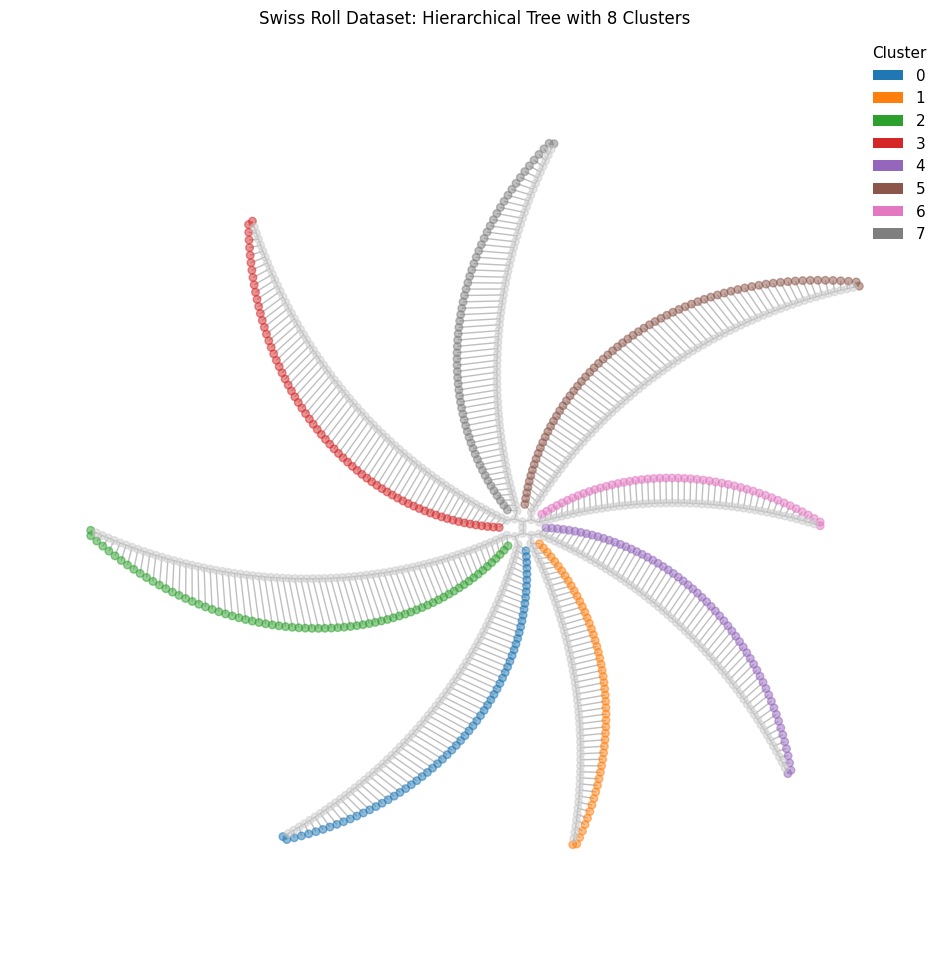

✓ Tree visualization complete


<Figure size 640x480 with 0 Axes>

In [14]:
# Visualize Cluster Tree Structure

# Debug: Check color mapping
from kl_clustering_analysis.plot.cluster_color_mapping import build_cluster_color_spec

print("\n" + "="*60)
print("DEBUG: Cluster Color Mapping")
print("="*60)
print(f"Number of clusters: {result_swiss['num_clusters']}")

spec = build_cluster_color_spec(
    result_swiss['num_clusters'], 
    base_cmap='viridis', 
    unassigned_color="#CCCCCC"
)


print("Generating tree visualization...")
print("Generating tree visualization...")
fig_tree, ax_tree = plot_tree_with_clusters(
    tree=tree_swiss,
    decomposition_results=result_swiss,
    results_df=results_df_swiss,  # includes Child_Parent_Divergence_* columns
    figsize=(12, 12),
    node_size=30,
    font_size=12,
    title=f"Swiss Roll Dataset: Hierarchical Tree with {result_swiss['num_clusters']} Clusters",
    colormap="tab10",  # good contrast
)

# Save tree visualization
plt.savefig('../cluster_tree_plots/swiss_roll_tree_structure.png', dpi=150, bbox_inches='tight')
print("✓ Tree visualization complete")

In [15]:
# Save Results to CSV

current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/swiss_roll_clustering_results_{current_date}.csv"

# Create results directory if it doesn't exist
os.makedirs('../results', exist_ok=True)

# Save the report
report_swiss.to_csv(results_file)

print(f"✓ Results saved:")
print(f"  - File: {results_file}")
print(f"  - Visualization: ../cluster_tree_plots/swiss_roll_clustering_test.png")
print(f"\n{'='*60}")
print(f"Test completed successfully!")
print(f"{'='*60}")


✓ Results saved:
  - File: ../results/swiss_roll_clustering_results_2025-12-20_04-20-37.csv
  - Visualization: ../cluster_tree_plots/swiss_roll_clustering_test.png

Test completed successfully!


# Post-Hoc Merging: Reducing Over-Splitting

**The Problem:** The algorithm finds 93 clusters (with rich features) which is extreme over-splitting.

**The Solution:** After initial decomposition, iteratively merge cluster pairs that are **NOT** significantly different according to the sibling JSD test.

**Algorithm:**
1. Start with all clusters from decomposition
2. Compute pairwise JSD p-values between all cluster distributions
3. Find the pair with the highest p-value (most similar)
4. If p-value > α, merge them (they're not significantly different)
5. Repeat until no more merges possible